### 1. Error de medición

**Definición**: Lectura incorrecta por fallo del instrumento (p. ej. saturación, ruido eléctrico, valores de «placeholder» como −9999).

**Implicaciones**: Introduce valores imposibles o extremos que distorsionan medias/varianzas.

**Detección**: reglas de sanity (rango válido), histogramas, valores constantes repetidos, z-score/IQR para detectar extremos absolutos.

**Qué hacer**: corregir si hay calibración/registro; si no, marcar como NA y reemplazar (imputación por vecinos o interpolación si es time series) o eliminar si son pocos. Documentar.

**Ejemplo**: Sensor de temperatura que registra 999 durante una hora por saturación.

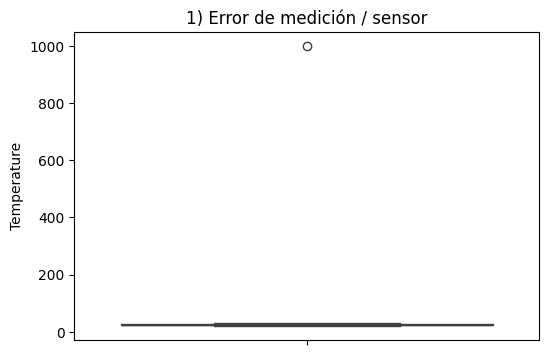

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset normal
np.random.seed(0)
data = np.random.normal(25, 2, 50)

# Error de sensor (valor imposible)
data = np.append(data, [999])

df = pd.DataFrame(data, columns=["Temperature"])

plt.figure(figsize=(6,4))
sns.boxplot(y=df["Temperature"])
plt.title("1) Error de medición / sensor")
plt.show()

### 2. Error humano

**Definición**: Valor incorrecto por digitación (coma mal puesta, cero extra, unidad equivocada).

**Implicaciones**: Outliers aislados que normalmente son corregibles.

**Detección**: validaciones de rango, detección de formatos, comparación con otras columnas (p. ej. edad > 150).

**Qué hacer**: intentar corregir (p. ej. mover coma decimal), pedir fuente o descartar si no hay soporte. Mantener registro de la corrección.

**Ejemplo**: Peso de una persona registrado como 700 (kg) en vez de 70.

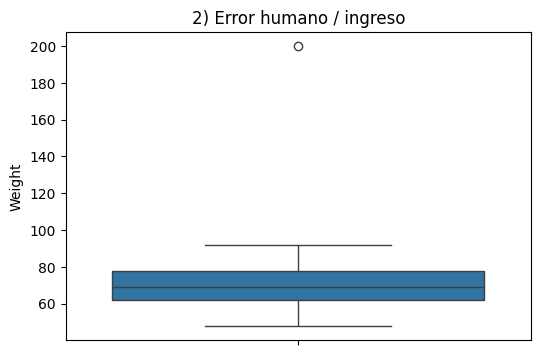

In [4]:
data = np.random.normal(70, 10, 50)
data = np.append(data, [200])  # valor mal digitado

df = pd.DataFrame(data, columns=["Weight"])

plt.figure(figsize=(6,4))
sns.boxplot(y=df["Weight"])
plt.title("2) Error humano / ingreso")
plt.show()

### 3. Valores extremos naturales

**Definición**: Observaciones legítimas pero en la cola de la distribución (cola pesada).

**Implicaciones**: No son “errores” — eliminarlos puede sesgar análisis; afectan medias y algunas métricas.

**Detección**: boxplot, cola de la distribución, tests de cola pesada; verificar con dominio.

**Qué hacer**: conservar y usar métodos robustos (mediana, IQR), transformar (log), o modelar con distribuciones de cola pesada; si son relevantes para la tarea (p. ej. detección de VIPs) crear categoría aparte.

**Ejemplo**: Ingresos personales donde aparecen multimillonarios.

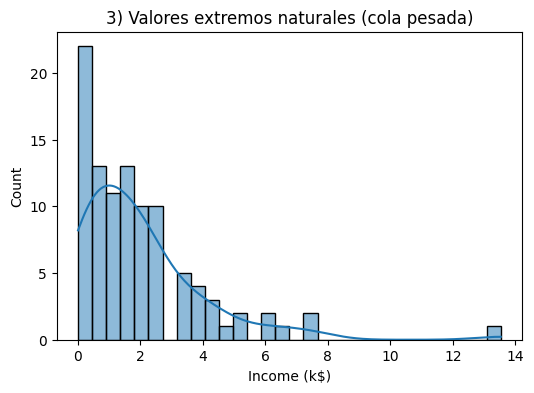

In [7]:
data = np.random.exponential(2, 100)  # cola pesada (valores grandes legítimos)

df = pd.DataFrame(data, columns=["Income (k$)"])

plt.figure(figsize=(6,4))
sns.histplot(df["Income (k$)"], bins=30, kde=True)
plt.title("3) Valores extremos naturales (cola pesada)")
plt.show()

### 4. Novedad / rareza

**Definición**: Caso raro y nuevo que puede señalar un fenómeno emergente (no es error).

**Implicaciones**: Puede ser lo más interesante (p. ej. nueva falla, nueva enfermedad).

**Detección**: modelos de novelty detection (One-Class SVM, Isolation Forest, autoencoders), revisión humana.

**Qué hacer**: investigar, etiquetar como nueva clase, monitorizar — no eliminar.

**Ejemplo**: Patrón de tráfico de red nunca visto que precede a un ataque.

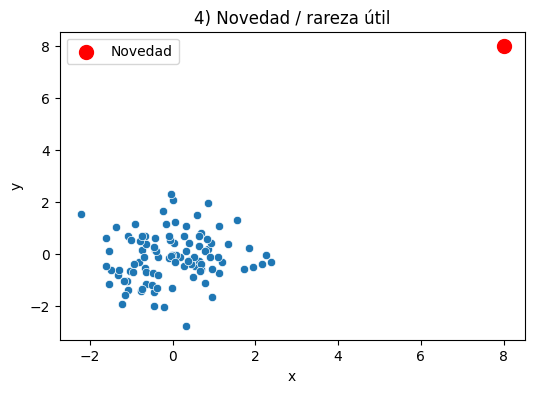

In [8]:
x = np.random.normal(0,1,100)
y = np.random.normal(0,1,100)

# Novedad: punto raro
x = np.append(x, [8])
y = np.append(y, [8])

df = pd.DataFrame({"x": x, "y": y})

plt.figure(figsize=(6,4))
sns.scatterplot(x="x", y="y", data=df)
plt.scatter(8,8, c="red", s=100, label="Novedad")
plt.legend()
plt.title("4) Novedad / rareza útil")
plt.show()

### 5. Outlier multivariado

**Definición**: No es extremo en una sola variable, pero la combinación de variables es improbable.

**Implicaciones**: Pasa desapercibido con análisis univariado; puede romper modelos lineales y de distancia.

**Detección**: distancia de Mahalanobis, Isolation Forest multivariado, PCA + ver residuos, modelos basados en densidad o vecinos.

**Qué hacer**: investigar, crear features que expliquen la combinación, considerar transformación o excluir si es error; si es real, usar modelos robustos o incluirlo como caso especial.

**Ejemplo**: Usuario joven (18) con historial crediticio y patrimonio tan alto como un magnate.

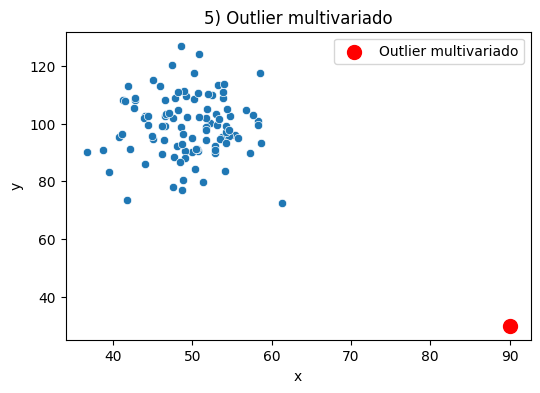

In [9]:
x = np.random.normal(50,5,100)
y = np.random.normal(100,10,100)

# Multivariado: combinación rara
x = np.append(x, [90])
y = np.append(y, [30])

df = pd.DataFrame({"x":x,"y":y})

plt.figure(figsize=(6,4))
sns.scatterplot(x="x", y="y", data=df)
plt.scatter(90,30,c="red",s=100,label="Outlier multivariado")
plt.legend()
plt.title("5) Outlier multivariado")
plt.show()

### 6. Outlier local

**Definición**: Anómalo respecto a sus vecinos locales aunque puede ser normal globalmente.

**Implicaciones**: Sensible en datos espaciales o agrupados; afecta clustering y recomendaciones.

**Detección**: LOF (Local Outlier Factor), DBSCAN (puntos fuera de clusters), kNN local.

**Qué hacer**: evaluar contexto local (vecindario/segmento), imputar o separar por grupo antes de modelar.

**Ejemplo**: Precio muy bajo de una casa dentro de una urbanización de alta gama.

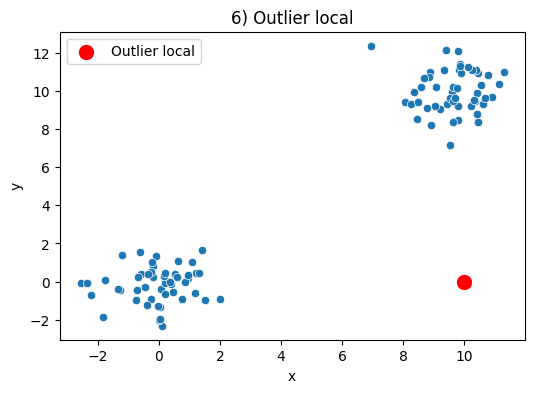

In [10]:
x = np.concatenate([np.random.normal(0,1,50), np.random.normal(10,1,50)])
y = np.concatenate([np.random.normal(0,1,50), np.random.normal(10,1,50)])

# Dentro de cluster derecho, punto raro
x = np.append(x, [10])
y = np.append(y, [0])

df = pd.DataFrame({"x":x,"y":y})

plt.figure(figsize=(6,4))
sns.scatterplot(x="x", y="y", data=df)
plt.scatter(10,0,c="red",s=100,label="Outlier local")
plt.legend()
plt.title("6) Outlier local")
plt.show()

### 7. Outlier contextual

**Definición**: Es anómalo sólo en un contexto (tiempo, ubicación, estación, dispositivo).

**Implicaciones**: requiere modelado que capture el contexto (p. ej. hora, día, temporada).

**Detección**: descomposición de series (STL), modelos estacionales, ventanas temporales, reglas basadas en contexto.

**Qué hacer**: modelar por contexto (features de tiempo), estacionalizar datos, detectar residuales; no eliminar sin entender contexto.

**Ejemplo**: Consumo eléctrico alto a medianoche durante un evento local (contextualmente anómalo).

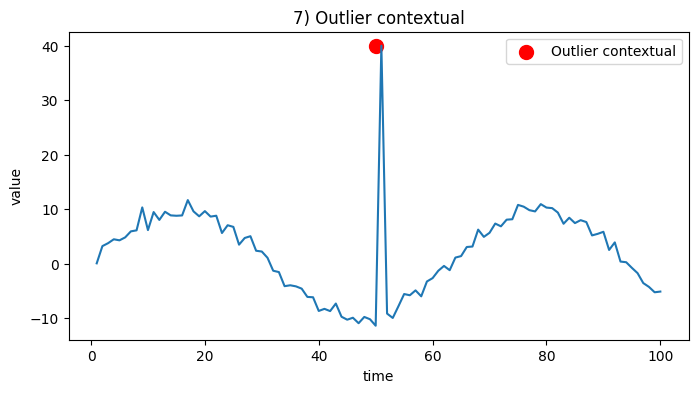

In [11]:
time = np.arange(1,101)
values = np.sin(time/10)*10 + np.random.normal(0,1,100)

# Valor anómalo en contexto (mucho más alto en medio)
values[50] = 40

df = pd.DataFrame({"time":time,"value":values})

plt.figure(figsize=(8,4))
sns.lineplot(x="time",y="value",data=df)
plt.scatter(50,40,c="red",s=100,label="Outlier contextual")
plt.legend()
plt.title("7) Outlier contextual")
plt.show()

### 8. Outlier colectivo

**Definición**: Un conjunto de observaciones juntas forman un patrón anómalo aunque individualmente no lo sean.

**Implicaciones**: típico en series temporales o logs; puede indicar fallo prolongado o ataque.

**Detección**: detección de anomalías en secuencias (HMM, LSTM/autoencoder secuencial, change-point detection), sliding windows.

**Qué hacer**: detectar intervalos, investigar causa raíz, criar alertas y, si procede, aislar periodo para modelado separado.

**Ejemplo**: Ráfaga de peticiones pequeñas repetidas a una API (DDoS leve).

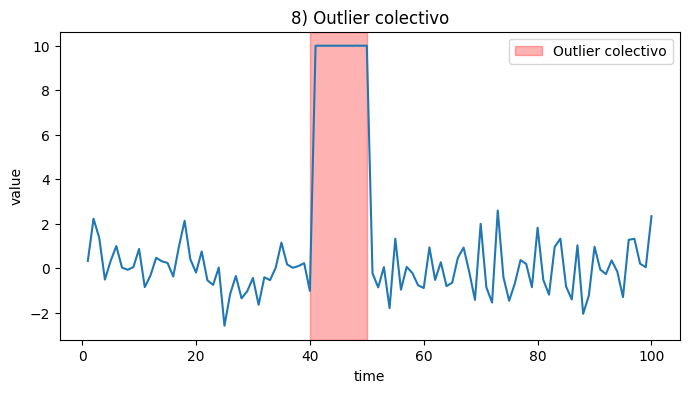

In [12]:
time = np.arange(1,101)
values = np.random.normal(0,1,100)

# Ráfaga anómala de valores altos
values[40:50] = 10

df = pd.DataFrame({"time":time,"value":values})

plt.figure(figsize=(8,4))
sns.lineplot(x="time",y="value",data=df)
plt.axvspan(40,50,color="red",alpha=0.3,label="Outlier colectivo")
plt.legend()
plt.title("8) Outlier colectivo")
plt.show()

### 9. Outlier por sesgo de muestreo

**Definición**: Observaciones raras porque la muestra no es representativa (submuestreo o sobre-muestreo).

**Implicaciones**: conclusiones sesgadas; outliers pueden reflejar población diferente.

**Detección**: comparar distribuciones con población conocida, tests de covariate shift.

**Qué hacer**: re-muestrear, aplicar ponderación / corrección por estratos, recolectar más datos representativos.

**Ejemplo**: Encuesta online sobre hábitos que recibe mayor respuesta de jóvenes, pocas respuestas de mayores.

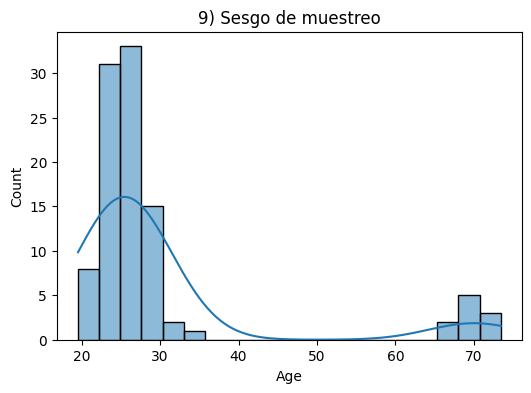

In [13]:
# La mayoría son jóvenes, pocos adultos mayores
ages = np.random.normal(25,3,90)
ages = np.append(ages, np.random.normal(70,2,10))

df = pd.DataFrame(ages, columns=["Age"])

plt.figure(figsize=(6,4))
sns.histplot(df["Age"], bins=20, kde=True)
plt.title("9) Sesgo de muestreo")
plt.show()

### 10. Cambio de concepto / drift

**Definición**: La relación entre variables cambia con el tiempo; antes válidos se vuelven outliers.

**Implicaciones**: Modelos desactualizados, rendimiento se degrada.
Detección: monitor de performance, tests de cambio (KS, ADWIN, change point), control de métricas.

**Qué hacer**: actualizar/reentrenar modelos, usar modelos adaptativos, alertas de drift.

**Ejemplo**: Comportamiento de compra que cambia drásticamente tras una crisis económica.

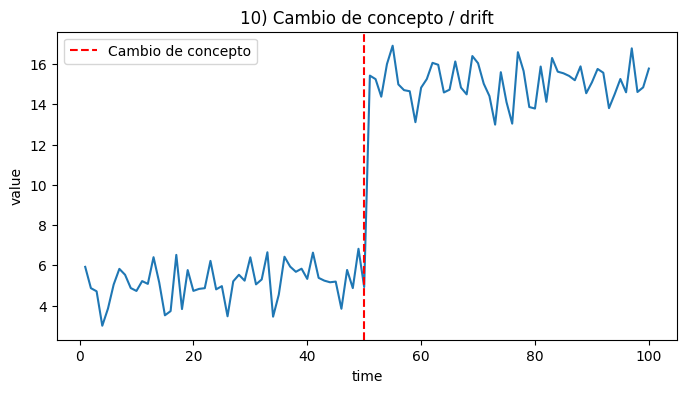

In [15]:
time = np.arange(1,101)
values = np.concatenate([np.random.normal(5,1,50), np.random.normal(15,1,50)])

df = pd.DataFrame({"time":time,"value":values})

plt.figure(figsize=(8,4))
sns.lineplot(x="time", y="value", data=df)
plt.axvline(50, color="red", linestyle="--", label="Cambio de concepto")
plt.legend()
plt.title("10) Cambio de concepto / drift")
plt.show()

### 11. Outlier derivado / operación inválida

**Definición**: Valores anómalos generados por transformaciones (división por cero, log de negativo) o agregaciones erróneas.

**Implicaciones**: Pueden romper pipelines y modelos (NaN, Inf).

**Detección**: revisar operaciones matemáticas, buscar NaN/Inf, verificar denominadores y dominios de funciones.

**Qué hacer**: arreglar la transformación (clamp, smoothing), filtrar o imputar, manejar excepciones en pipeline.

**Ejemplo**: Ratio precio / cantidad donde cantidad = 0 → Inf.

/tmp/ipython-input-791260191.py:3: RuntimeWarning: divide by zero encountered in divide
  ratio = num / den.astype(float)


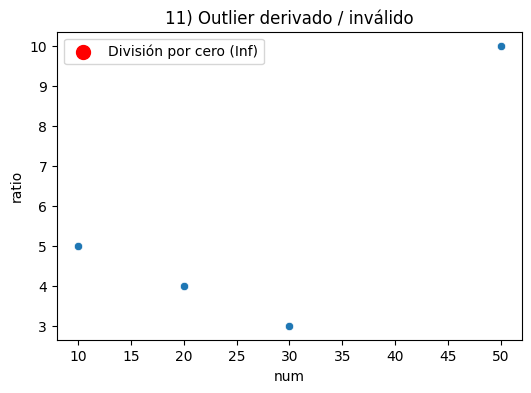

In [16]:
num = np.array([10,20,30,40,50])
den = np.array([2,5,10,0,5])  # división por cero en un caso
ratio = num / den.astype(float)

df = pd.DataFrame({"num":num,"den":den,"ratio":ratio})

plt.figure(figsize=(6,4))
sns.scatterplot(x="num", y="ratio", data=df)
plt.scatter(40, ratio[3], c="red", s=100, label="División por cero (Inf)")
plt.legend()
plt.title("11) Outlier derivado / inválido")
plt.show()

### 12. Outlier malicioso / fraude

**Definición**: Observaciones deliberadamente manipuladas para engañar (fraude, spam, evasión).

**Implicaciones**: alto coste; requieren detección especializada y etiquetado.

**Detección**: modelos supervisados con labels de fraude, features específicas (velocidad, geolocalización inconsistente), técnicas de anomaly detection con feedback humano.

**Qué hacer**: convertir a problema supervisado si hay ejemplos, crear reglas/hard thresholds, alertas y acciones (bloqueo, verificación manual).

**Ejemplo**: Transacción de tarjeta en país distinto minutos después de otra compra lejos.

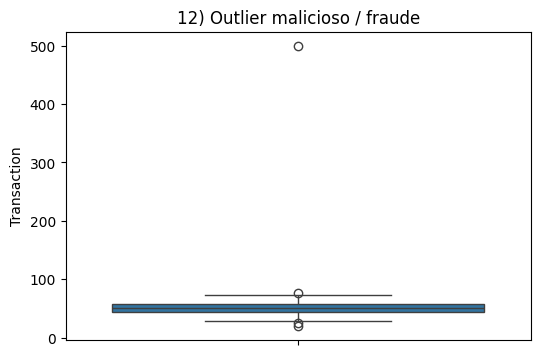

In [19]:
amounts = np.random.normal(50,10,100)
# Transacción fraudulenta muy alta
amounts = np.append(amounts, [500])

df = pd.DataFrame(amounts, columns=["Transaction"])

plt.figure(figsize=(6,4))
sns.boxplot(y=df["Transaction"])
plt.title("12) Outlier malicioso / fraude")
plt.show()

## Mini-workflow práctico para decidir qué hacer con un outlier

	1. **Visualizar**: histogramas, boxplots, scatter, series temporales.
	2. **Investigar**: revisar origen (sensor, ingreso manual, ETL), metadatos, logs — preguntar a quien conoce la fuente.
	3. **Clasificar**: ¿es error, novedad, multivariado, contextual, fraudulento, drift…?
	4. **Actuar según tipo**:
      - Errores → corregir o imputar / eliminar (documentar).
	    - Legítimos / novedades → conservar, etiquetar, modelar con robustez.
	    - Fraude → etiquetar y entrenar detectores; activar procesos de seguridad.
	    - Drift → reentrenar/monitorizar.
	5. **Modelado**: si no se puede limpiar, usar modelos robustos (árboles, IsolationForest, losses robustas) o transformar variables (log, winsorize).
	6. **Documentar**: todas las decisiones para reproducibilidad.